In [1]:
from __future__ import print_function

"""
A script to run the cqed_rhf and cqed_cis method on MgH+ potential energy surface in a cc-pVDZ basis set,
reproducing data from Figure 3 by McTague and Foley.
"""

__authors__   = ["Jon McTague", "Jonathan Foley"]
__credits__   = ["Jon McTague", "Jonathan Foley"]

__copyright_amp__ = "(c) 2014-2018, The Psi4NumPy Developers"
__license__   = "BSD-3-Clause"
__date__      = "2021-01-15"

# ==> Import Psi4, NumPy, & SciPy <==
import psi4
import numpy as np
from helper_cqed_rhf import *
from helper_cis import *
from helper_cs_cqed_cis import *
from psi4.driver.procrouting.response.scf_response import tdscf_excitations
from matplotlib import pyplot as plt
# Set Psi4 & NumPy Memory Options
psi4.set_memory('2 GB')
psi4.core.set_output_file('output.dat', False)

numpy_memory = 2



  Memory set to   1.863 GiB by Python driver.


Methods to fit Pauli-Fierz and Jaynes-Cummings models to CIS data for the ground- and excited-state
of a quantum system (including transition dipole moments in both cases, and the total dipole
moments in the Pauli-Fierz case) given a photon frequency and coupling strength.

In [2]:
# functions for Pauli-Fierz and Jaynes-Cummings model Hamiltonians

def pauli_fierz(e1, e2, omega, lam, mu_g, mu_e, mu_eg):
    H = np.zeros((3,3),dtype=complex)
    l_d_mu_g = np.dot(lam, mu_g)
    l_d_mu_e = np.dot(lam, mu_e)
    l_d_tdm  = np.dot(lam, mu_eg)
    
    H[0,0] = e1 + 0.5 * l_d_mu_g ** 2
    H[1,1] = e1 + omega + 0.5 * l_d_mu_g ** 2
    H[2,2] = e2 + 0.5 * l_d_mu_e ** 2
    H[1,2] = np.sqrt(omega/2) * l_d_tdm
    H[2,1] = np.sqrt(omega/2) * l_d_tdm

    
    # diagonalize
    vals, vecs = la.eig(H)
    idx = vals.argsort()[::1]
    vals = vals[idx]
    return vals[0], vals[1], vals[2]

def jaynes_cummings(e1, e2, omega, lam, mu_eg):
    H = np.zeros((3,3),dtype=complex)
    l_d_tdm = np.dot(lam, mu_eg)
    H[0,0] = e1 + omega
    H[1,1] = e2
    H[0,1] = np.sqrt(omega/2) * l_d_tdm
    H[1,0] = np.sqrt(omega/2) * l_d_tdm
    
    # diagonalize
    vals, vecs = la.eig(H)
    idx = vals.argsort()[::1]
    vals = vals[idx]
    return vals[0], vals[1]


# Quick validation
In the next cell, we will just run a quick test of helper_cis() and helper_cqed_cis() against psi4's CIS.
Note that helper_cis is just ordinary cis but also returns the dipole expectation value of
excited CIS states, which to my knowledge is not available through psi4.
The function helper_cs_cqed_cis() is the cqed-cis method in the coherent state basis.
If the lambda_vector = 0, then all three of these methods should return the same excited-state energies.

In [3]:
mol_str = """
Mg
H 1 1.3
symmetry c1
1 1
"""

# options dict
options_dict = {'basis': 'cc-pVDZ',
               'save_jk': True, 
               'scf_type': 'pk'}

# set psi4 options and geometry
psi4.set_options(options_dict)
mol = psi4.geometry(mol_str)

om = 0.
lam = np.array([0.,0.,0.])

n_states = 5

# run psi4 SCF
psi4_rhf_e, wfn = psi4.energy("scf/cc-pVDZ", return_wfn=True, molecule=mol)
    
# calculate the excited-state energies and save them to a dictionary called 'res'
res = tdscf_excitations(wfn, states=n_states, triplets = "NONE", tda=True)

# parse res for excitation energies
psi4_excitation_e = [r["EXCITATION ENERGY"] for r in res]

# run helper_cis()
cis_e, cis_c, cis_mu, tdm = cis(mol_str, options_dict)

# run helper_cs_cqed_cis()
cqed_dict = cs_cqed_cis(lam, om, mol_str, options_dict)

cqed_cis_e = cqed_dict['CQED-CIS ENERGY']
scf_e = cqed_dict['RHF ENERGY']

# collect corresponding excitation energies for comparison
cqed_cis_to_compare = cqed_cis_e[::2]

# check to see that the cis energies match psi4s!
assert( np.isclose(psi4_rhf_e, scf_e))
assert( np.allclose(psi4_excitation_e, cis_e[:n_states]))
assert( np.allclose(psi4_excitation_e, cqed_cis_to_compare[1:n_states+1]))

6
23
17
printing eps
[-4.93378214e+01 -4.08104916e+00 -2.60023568e+00 -2.59573445e+00
 -2.59573445e+00 -6.60357641e-01 -2.32876194e-01 -1.47374494e-01
 -1.47374494e-01 -4.53942072e-02 -7.49339147e-03  5.97810350e-02
  5.97810350e-02  1.09321067e-01  1.97047575e-01  1.97047575e-01
  2.09496069e-01  2.09496069e-01  3.61036188e-01  8.93714749e-01
  1.54520555e+00  1.54520555e+00  1.61326052e+00]

Number of occupied orbitals: 6

Start SCF iterations:

Canonical RHF One-electron energy = -285.7424508862665675
CQED-RHF One-electron energy      = -285.7424508862665675
Nuclear repulsion energy          = 4.8847127138769233
Dipole energy                     = 0.0000000000000000
SCF Iteration   1: Energy = -199.8574439988286713   dE = -1.99857E+02   dRMS = 1.39184E-08
SCF Iteration   2: Energy = -199.8574439988290408   dE = -3.69482E-13   dRMS = 3.89537E-09
Total time for SCF iterations: 0.007 seconds 

QED-RHF   energy: -199.85744400 hartree
Psi4  SCF energy: -199.85744400 hartree


# MgH+ Polaritonic Potential Energy Surfaces

Run the block below to compute data for Figure 3: scan of the CS-CQED-CIS energies
for the lower- and upper-polariton states of MgH+ in a cc-pVDZ basis set coupled to a photon
with frequency 4.75 eV and lambda magnitude 0.0125 atomic units polarized in the z-direction.  The top panel (Figure 3 a) is generated by setting 
`om = om_r`
and the bottom panel (Figure 3b) is generated by setting
`om = oom_r - 4 * (g_max/2) * 1j`

In [10]:
# template for z-matrix
mol_tmpl = """
Mg
H 1 **R**
symmetry c1
1 1
"""

# set psi4 options
psi4.set_options(options_dict)
# array of bondlengths for MgH+
r_array = np.array([1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.0,2.1,2.2,2.3, 2.4, 2.5, 2.6, 2.7]) #, 2.8, 2.9, 3.0, 3.1, 3.2, 3.3])
#r_array = np.array([2.0, 2.1, 2.2, 2.3, 2.4])
# arrays to hold psi4 cis quantities to fit the model PF Hamiltonian with
# array for transition dipole moments
tdm_array = np.zeros((3, len(r_array)))

# array for total diplole of ground and excited state 
dipole_array = np.zeros((3,2,len(r_array)))

# array for ordinary cis
cis_energy_array = np.zeros((5,len(r_array)))

# array to hold the cs-cqed-cis energies
# array for cqed cis
cqed_cis_energy_array = np.zeros((5,len(r_array)),dtype=complex)

# array for model Pauli-Fierz energies
pf = np.zeros((3,len(r_array)),dtype=complex)

# array for Jaynes-Cummings energies
jc = np.zeros((2,len(r_array)),dtype=complex)

# electric field strength 
lam_z = 0.0125

# photon energy
om_r = 4.75 / 27.211

# approximate maximum value of transition dipole moment in a.u.
max_tdm = 2.25

# approximate max value of g
g_max = np.sqrt(om_r/2) * lam_z * max_tdm

print(" value of gamma to cross over from weak to strong coupling:", 4 * g_max)
#om = om_r #-> Figure 3a

om = om_r - 4 * (g_max/2) * 1j #-> Figure 3b

# lambda vector
lam = np.array([0,0,lam_z])

# loop over the different bond-lengths, create different instances
# of MgH+ molecule and compute and store various quantities
ctr = 0
for r in r_array:
    molstr = mol_tmpl.replace("**R**", str(r))
    mol = psi4.geometry(molstr)
    e, wfn = psi4.energy("scf/cc-pVDZ", return_wfn=True, molecule=mol)
    
    # confirm our cis agrees with psi4
    res = tdscf_excitations(wfn, states=3, triplets = "NONE", tda=True)
    
    # parse res for excitation energies
    psi4_excitation_e = [r["EXCITATION ENERGY"] for r in res]
    
    cis_e, cis_c, cis_mu, tdm = cis(molstr, options_dict)
    
    cis_energy_array[0,ctr] = e
    cis_energy_array[1:5,ctr] = e+cis_e[0:4]
    
    pf[0,ctr], pf[1,ctr], pf[2,ctr] = pauli_fierz(e, e+cis_e[0], om, lam, cis_mu[:,0], cis_mu[:,1], tdm)
    jc[0,ctr], jc[1,ctr] = jaynes_cummings(e, e+cis_e[0], om, lam,  tdm)
    
    assert np.isclose(cis_e[0], psi4_excitation_e[0])
    assert np.isclose(cis_e[1], psi4_excitation_e[1])
    
    cqed_dict = cs_cqed_cis(lam, om, molstr, options_dict)
    
    # get cqed-rhf energy
    cqed_scf_e = cqed_dict['CQED-RHF ENERGY']
    # get cqed-cis excitation energies
    cqed_cis_e = cqed_dict['CQED-CIS ENERGY']
    # store to arrays
    cqed_cis_energy_array[0:5,ctr] = cqed_scf_e+cqed_cis_e[0:5]
    ctr+=1
    

 

 value of gamma to cross over from weak to strong coupling: 0.033236254686047906
6
23
17
printing eps
[-4.93764165e+01 -4.10048936e+00 -2.61947471e+00 -2.61947471e+00
 -2.61634588e+00 -5.79706176e-01 -2.50448422e-01 -1.50469351e-01
 -1.50469351e-01 -5.47601560e-02 -1.35115296e-02  5.86604200e-02
  5.86604200e-02  6.25487342e-02  2.03786669e-01  2.03786669e-01
  2.04888167e-01  2.04888167e-01  3.20042119e-01  6.44449298e-01
  1.41117363e+00  1.41117363e+00  1.71015208e+00]

Number of occupied orbitals: 6

Start SCF iterations:

Canonical RHF One-electron energy = -282.2898820081355211
CQED-RHF One-electron energy      = -282.2901171135008553
Nuclear repulsion energy          = 3.1750632640200003
Dipole energy                     = 0.0008827413911168
SCF Iteration   1: Energy = -199.8812587213678569   dE = -1.99881E+02   dRMS = 2.21975E-05
SCF Iteration   2: Energy = -199.8812595818004922   dE = -8.60433E-07   dRMS = 8.34190E-06
SCF Iteration   3: Energy = -199.8812596865763282   dE = -1

In the weak-coupling case, there is a crossing between the the states, and because we are sorting the
eigenvalues in ascending order, we will not see the curve crossing as expected... to do so we must reorder the
arrays that store the jc, pf, and cqed_cis eigenvalues after the bondlength at which the crossing occurs (~2.2 Angstroms, or index 9 of r_array above).  Uncomment and run the block below to do this!

In [ ]:
#safe_jc = np.copy(jc)
#safe_pf = np.copy(pf)
#safe_cqed_cis = np.copy(cqed_cis_energy_array)
#print(r_array[9:])
#tmp = np.copy(cqed_cis_energy_array[1,9:])
#cqed_cis_energy_array[1,9:] = np.copy(cqed_cis_energy_array[2,9:])
#cqed_cis_energy_array[2,9:] = np.copy(tmp)

#tmp_jc_lp = jc[1,9:]
#tmp_pf_up = pf[1,9:]
#tmp_pf_lp = pf[2,9:]
#tmp_cqed_cis_up = cqed_cis_energy_array[1,9:]
#tmp_cqed_cis_lp = cqed_cis_energy_array[2,9:]

#jc = np.copy(safe_jc)
#pf = np.copy(safe_pf)
#cqed_cis_energy_array = np.copy(safe_cqed_cis)

Plot the polaritonic surfaces from the different levels of theory against the CIS electronic surfaces.

/opt/conda/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


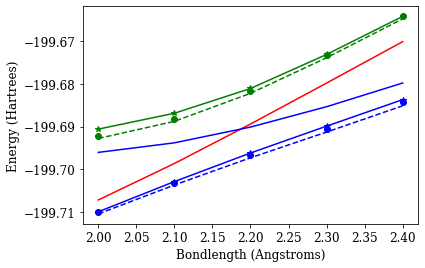

In [11]:
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib import rcParams


rcParams['font.family'] = 'serif'
rcParams['font.size'] = 12

plt.plot(r_array, cis_energy_array[0,:]+om, 'red', label='X,1')
plt.plot(r_array, cis_energy_array[1,:], 'blue', label='A,0')
plt.plot(r_array, np.real(jc[0,:]), 'b--', label="JC LP")
plt.plot(r_array, np.real(jc[1,:]), 'g--', label="JC UP")
plt.plot(r_array, np.real(pf[1,:]), 'b-*', label="PF LP")
plt.plot(r_array, np.real(pf[2,:]), 'g-*', label="PF UP")
plt.plot(r_array, np.real(cqed_cis_energy_array[1,:]), 'bo', label="CQED-CIS LP")
plt.plot(r_array, np.real(cqed_cis_energy_array[2,:]), 'go', label="CQED-CIS UP")

plt.xlabel("Bondlength (Angstroms)")
plt.ylabel("Energy (Hartrees)")
#plt.legend()
plt.show()

Write the data to a file!

In [ ]:
f = open('MgH_ccpVDZ_Ez_12.5mH_om_4.75_0g.txt', 'w')
stri = "radius; CIS X,1; CIS A,0; JC LP; JC UP; PF LP; PF UP; CQED-CIS LP; CQED-CIS UP"
f.write(" %s \n" % stri)
ctr=0
for r in r_array:
    f.write("%6.3f %12.6f %12.6f %12.6f %12.6f %12.6f %12.6f %12.6f %12.6f \n" % 
            (r, cis_energy_array[0,ctr]+np.real(om), cis_energy_array[1,ctr], 
            np.real(jc[0,ctr]),np.real(jc[1,ctr]), 
            np.real(pf[1,ctr]),np.real(pf[2,ctr]),
            np.real(cqed_cis_energy_array[1,ctr]),np.real(cqed_cis_energy_array[2,ctr])))
    ctr += 1
    
f.close()

Run the cell below to compute the data for Figure 2: scan of ground-state energy
of MgH+ coupled to a photon with energy 4.75 eV and lambda = 0.075 atomic units polarized along z
at the RHF/cc-pVDZ, CQED-RHF/cc-pVDZ, and CQED-CIS/cc-pVDZ levels.

In [ ]:
# set psi4 options
psi4.set_options(options_dict)
# array of bondlengths for MgH+
r_array = np.array([1.3,1.35,1.4,1.45,1.5,1.55,1.6,1.65, 1.7, 1.75,1.8,1.9,2.0,2.1,2.2,2.3, 2.4, 2.5, 2.6, 2.7]) #, 2.8, 2.9, 3.0, 3.1, 3.2, 3.3])

# array for ground state at different levels of theory
gs_energy_array = np.zeros((3,len(r_array)),dtype=complex)


# approximate maximum value of transition dipole moment in a.u.
max_tdm = 2.25
# electric field strength 
lam_z = 0.075

# photon energy
om_r = 4.75 / 27.211


# lambda vector
lam = np.array([0,0,lam_z])


# loop over the different bond-lengths, create different instances
# of MgH+ molecule and compute and store various quantities
ctr = 0
for r in r_array:
    molstr = mol_tmpl.replace("**R**", str(r))
    
    cqed_dict = cs_cqed_cis(lam, om_r, molstr, options_dict)
    
    # get ordinary rhf energy
    gs_energy_array[0,ctr] = cqed_dict['RHF ENERGY']
    # get cqed-rhf energy
    gs_energy_array[1,ctr] = cqed_dict['CQED-RHF ENERGY']
    
    # get cqed-cis ground state
    cqed_cis_e = cqed_dict['CQED-CIS ENERGY']
    
    # store to arrays
    gs_energy_array[2,ctr] = cqed_cis_e[0]+cqed_dict['CQED-RHF ENERGY']
    
    ctr+=1
    

 

In [ ]:
# plot the ground-state potential energy surfaces
plt.plot(r_array, gs_energy_array[0,:], label='RHF')
plt.plot(r_array, gs_energy_array[1,:], label='CQED-RHF')
plt.plot(r_array, gs_energy_array[2,:], label='CQED-CIS')
plt.legend()
plt.show()


In [ ]:
# write the data to file!
f = open('MgH_gs_lamz_7.5mH_om_4.75.txt', 'w')
stri = "r; rhf_e, cqed_rhf_e, cqed_cis_e"
f.write(" %s \n" % stri)
ctr=0
for r in r_array:
    f.write("%6.3f %12.6f %12.6f %12.6f \n" % 
            (r, gs_energy_array[0,ctr], gs_energy_array[1,ctr], gs_energy_array[1,ctr]+gs_energy_array[2,ctr]))
    ctr += 1
    
f.close()